In [1]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
from torch import nn
from torch import optim
from torch.autograd import Variable
from torch.autograd import grad
import scipy.linalg as sp

from scipy.stats import norm
import math
import numpy as np
import os
import time
from numpy import save
from numpy import load

from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

#from etdrk_allen_cahn import etdrk_allen_cahn

The 1D Allen-Cahn equation is given by

$$
\frac{\partial u}{\partial t} = \epsilon \frac{\partial^2 u}{\partial x^2} + u - u^3
$$

We solve for $x \in [-1,1], t \in [0, 70],$ with $\epsilon=0.01,$ subject to Dirichlet boundary conditions

$$
u(-1,t) = -1 \\
u(1,t) = 1
$$

and the initial condition

$$
u(x,0) = 0.53x + 0.47 \sin(-1.5\pi x) 
$$

Using the rescaling $t' = t/70$, we obtain

$$
\frac{\partial u}{\partial t'} = \frac{1}{70} \left(\epsilon \frac{\partial^2 u}{\partial x^2} + u - u^3\right)
$$

which we now solve for $t' \in [0,1]$.

In [2]:
# Code adapted from: https://ora.ox.ac.uk/objects/uuid:223cd334-15cb-4436-8b77-d30408f684c5/download_file?safe_filename=NA-03-14.pdf&file_format=application%2Fpdf&type_of_work=Report

def etdrk_allen_cahn(nx, nt):

    def cheb(nx):
        if nx == 0:
            return (0, 1)
        x = np.cos(np.pi*np.arange(0, nx+1)/nx)
        c = -1*(np.array((nx-1)*[1]))
        c = np.array([2]+[c_i**2 if i%2==1 else c_i for i, c_i in enumerate(c)]+[2]).reshape(-1,1)
        XT = np.tile(x,(nx+1,1))
        X = XT.T
        dX = X-XT
        D = (c*(1/c).T) / (dX+np.eye(nx+1))
        D = D - np.diag(np.sum(D.T, axis=0))
        return (D, x.reshape(-1,1))

    D, x = cheb(nx)
    x = x[1:nx]
    w = 0.53*x + 0.47*np.sin(-1.5*np.pi*x) - x
    u = w+x
    u = np.insert(u,0,1)
    u = np.append(u,-1).reshape(-1,1)

    h = 0.25
    M = 32
    r = 15*np.exp(1j*np.pi*(np.arange(1,M+1)-0.5)/M)
    L = np.matmul(D,D)
    L = 0.01*L[1:nx,1:nx]
    A = h*L
    E = sp.expm(A)
    E2 = sp.expm(A/2)
    I = np.eye(nx-1)
    Z = np.zeros((nx-1, nx-1))
    f1 = Z
    f2 = Z
    f3 = Z
    Q = Z

    for j in range(1, M+1):
        z = r[j-1]
        zIA = sp.inv(z*I-A)
        Q = Q + h*zIA*(np.exp(z/2)-1)
        f1 = f1 + h*zIA*(-4-z+np.exp(z)*(4-3*z+(z**2)))/(z**2)
        f2 = f2 + h*zIA*(2+z+np.exp(z)*(z-2))/(z**2)
        f3 = f3 + h*zIA*(-4-3*z-(z**2)+np.exp(z)*(4-z))/(z**2)
        
    f1 = np.real(f1/M)
    f2 = np.real(f2/M)
    f3 = np.real(f3/M)
    Q = np.real(Q/M)

    uu = u
    tt = [0]
    tmax = nt
    nmax = int(np.round(tmax/h))
    nplt = int(np.floor((tmax/nt)/h))

    for n in range(1, nmax+1):
        t = n*h
        Nu = (w+x) - (w+x)**3
        a = E2@w + Q@Nu
        Na = a + x - (a+x)**3
        b = E2@w + Q@Na
        Nb = b + x - (b+x)**3
        c = E2@a + Q@(2*Nb-Nu)
        Nc = c + x - (c+x)**3
        w = E@w + f1@Nu + 2*f2@(Na+Nb) + f3@Nc
        if n % nplt == 0:
            u = w+x
            u = np.insert(u,0,1)
            u = np.append(u,-1).reshape(-1,1)
            uu = np.append(uu, u, axis=1)
            tt.append(t)
    tt = np.array(tt)
    tt /= nt
    x = np.insert(x.flatten(),0,1)
    x = np.append(x, -1)

    return x, tt, uu

(101,) (36,) (101, 36)


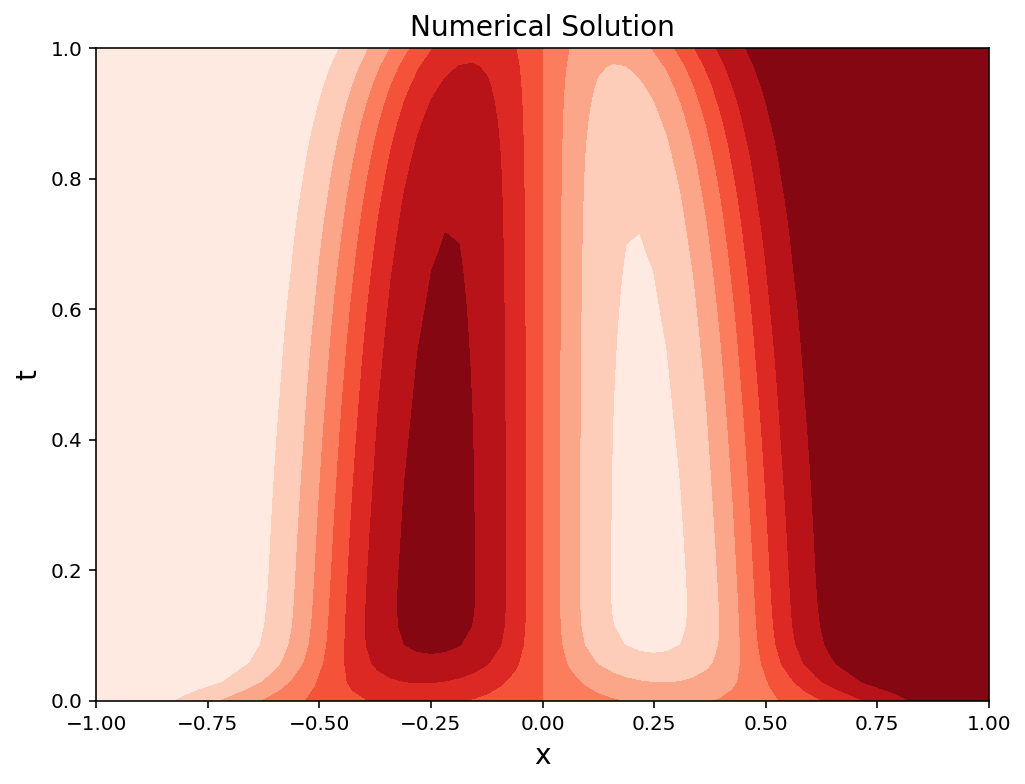

In [50]:
# specify number of points
nx_p = 100
nt_p = 35

# define x-axis and t-axis
x_axis_num, t_axis_num, sol = etdrk_allen_cahn(nx_p, nt_p)
print(x_axis_num.shape, t_axis_num.shape, sol.shape)
x_grid_num, t_grid_num = np.meshgrid(x_axis_num, t_axis_num)

fig, ax = plt.subplots(figsize=(8,6))
ax.set_title('Numerical Solution', fontsize=14)
ax.set_xlabel('x', fontsize=14), ax.set_ylabel('t', fontsize=14)
cf = ax.contourf(x_grid_num, t_grid_num, sol.T, cmap="Reds")

In [4]:
def nth_derivative(f, wrt, n):
    for i in range(n):
        grads = grad(f, wrt, create_graph=True, allow_unused=True)[0]
        f = grads
        if grads is None:
            print('bad grad')
            return torch.tensor(0.)
    return grads

In [5]:
def flat(x):
    m = x.shape[0]
    return [x[i] for i in range(m)]

In [30]:
class MLP_2D(nn.Module):
    
    def __init__(self, equation, init_cond):
        super().__init__()
        self.equation = equation
        
        # initial & boundary conditions: IBVP1D (Dirichlet-Dirichlet)
        self.t_min, self.t_min_val, self.x_min, self.x_min_val, self.x_max, self.x_max_val = init_cond
        
        # add layers
        self.hidden1 = nn.Linear(2,80)
        self.hidden2 = nn.Linear(80,80)
        self.hidden3 = nn.Linear(80,80)
        self.hidden4 = nn.Linear(80,40)
        self.out = nn.Linear(40,1)
        self.tn = nn.Tanh()
        self.layers = nn.ModuleList([self.hidden1, self.hidden2, self.hidden3, self.hidden4, self.out])
        
    def forward(self, x, t):
        # do forward pass
        u = torch.cat((x, t), 1)
        u = self.hidden1(u)
        for l in self.layers[1:]:
            u = l(self.tn(u))
        
        # re-parametrize (for IBVP1D (Dirichlet-Dirichlet))
        x_tilde = (x - self.x_min)/(self.x_max - self.x_min)
        t_tilde = t - self.t_min
        t0 = self.t_min*torch.ones_like(t, requires_grad=True)
        Axt = self.t_min_val(x) + \
              x_tilde*(self.x_max_val(t) - self.x_max_val(t0)) + \
              (1 - x_tilde)*(self.x_min_val(t) - self.x_min_val(t0))
        
        # enforce initial conditions (for IBVP1D (Dirichlet-Dirichlet))
        u = Axt + x_tilde*(1 - x_tilde)*(1 - torch.exp(-t_tilde))*u
        return u
    
    def simple_loss(self, x, t):
        u_tilde = self(x, t)
        u_t_tilde = nth_derivative(flat(u_tilde), wrt=t, n=1)
        u_x_tilde = nth_derivative(flat(u_tilde), wrt=x, n=1)
        u_xx_tilde = nth_derivative(flat(u_x_tilde), wrt=x, n=1)
        res_tilde = self.equation(u_tilde, u_t_tilde, u_xx_tilde)
        loss = (res_tilde**2).mean()
        return loss

In [67]:
# specify training domain
x_min = -1.0 
x_max = 1.0
t_min = 0.0 
t_max = 0.45 #40.0 # 70.0

# specify number of training points
nx = 20
nt = 20

# generate training points 
x = torch.linspace(x_min, x_max, nx, requires_grad=True)
t = torch.linspace(t_min, t_max, nt, requires_grad=True)
grid_x, grid_t = torch.meshgrid(x, t)
x_train, t_train = grid_x.flatten().unsqueeze(0).t(), grid_t.flatten().unsqueeze(0).t()

# initial conditions
init_cond = (t_min, lambda x: 0.53*x + 0.47*torch.sin(-1.5*np.pi*x), x_min, lambda t: -1*torch.ones_like(t), x_max, lambda t: torch.ones_like(t))

# differential equation (Allen-Cahn equation)
equation = lambda u, u_t, u_xx: (1/70)*u_t - 0.01*u_xx - u + u**3

# instantiate network
model_2D = MLP_2D(equation, init_cond)
model_2D.load_state_dict(torch.load('weights_allen_cahn.t.44'))

# train the model

# choose optimizer
optimizer = optim.SGD(model_2D.parameters(), lr=0.12, momentum=0.92, nesterov=True)

# train
epochs = 200000
loss_vals = []
for epoch in range(epochs):
    
    loss = model_2D.simple_loss(x_train, t_train)
    
    optimizer.zero_grad()
    loss.backward()
    loss_vals.append(loss.item())
    optimizer.step()
    
    if epoch % 1000 == 999:
        with torch.no_grad():
            print(f'Epoch: {epoch + 1} Loss: {loss.item()}')

Epoch: 1000 Loss: 0.00011086387530667707
Epoch: 2000 Loss: 0.00011063181591453031
Epoch: 3000 Loss: 0.00011040788376703858
Epoch: 4000 Loss: 0.00011018772784154862
Epoch: 5000 Loss: 0.00010997013305313885
Epoch: 6000 Loss: 0.00010975437908200547
Epoch: 7000 Loss: 0.00010954072786262259
Epoch: 8000 Loss: 0.00010932892473647371
Epoch: 9000 Loss: 0.00010911835124716163
Epoch: 10000 Loss: 0.0001089102152036503
Epoch: 11000 Loss: 0.00010870287223951891
Epoch: 12000 Loss: 0.00010849635145859793
Epoch: 13000 Loss: 0.00010829057282535359
Epoch: 14000 Loss: 0.00010808578372234479
Epoch: 15000 Loss: 0.00010788212239276618
Epoch: 16000 Loss: 0.0001076802727766335
Epoch: 17000 Loss: 0.00010747945634648204
Epoch: 18000 Loss: 0.00010728175402618945
Epoch: 19000 Loss: 0.00010708682384574786
Epoch: 20000 Loss: 0.00010689362534321845
Epoch: 21000 Loss: 0.00010670375922927633
Epoch: 22000 Loss: 0.00010651534103089944
Epoch: 23000 Loss: 0.00010632809426169842
Epoch: 24000 Loss: 0.00010614146594889462
Epo

Epoch: 198000 Loss: 8.538222755305469e-05
Epoch: 199000 Loss: 8.53113378980197e-05
Epoch: 200000 Loss: 8.5240593762137e-05


In [65]:
## save/load weights

torch.save(model_2D.state_dict(), 'weights_allen_cahn.t.44')
#model_2D.load_state_dict(torch.load('weights_allen_cahn.t7'))

In [63]:
# prepare for plotting

# specify domain
x_min_p = -1.0
x_max_p = 1.0
t_min_p = 0.0
t_max_p = 0.44 #40.0 #70.0

# specify number of points
nx_p = 100
nt_p = 31

# define x-axis and t-axis
x_axis_num, t_axis_num, sol = etdrk_allen_cahn(nx_p, nt_p)
x_grid_num, t_grid_num = np.meshgrid(x_axis_num, t_axis_num)
x_axis = np.linspace(x_min_p, x_max_p, nx_p+1)
t_axis = np.linspace(t_min_p, t_max_p, nt_p+1)
x_grid, t_grid = np.meshgrid(x_axis, t_axis)

# x-axis and t-axis as torch tensors
x_axis_tch = torch.from_numpy(x_axis).float().reshape(nx_p+1, 1, 1)
t_axis_tch = torch.from_numpy(t_axis).float().reshape(nt_p+1, 1, 1)

# get the solution matrix
u_nn = np.zeros((nx_p+1, nt_p+1))
for i in range(0, nx_p+1):
    for j in range(0, nt_p+1):
        u_nn[i][j] = model_2D(x_axis_tch[i], t_axis_tch[j]).detach().numpy()

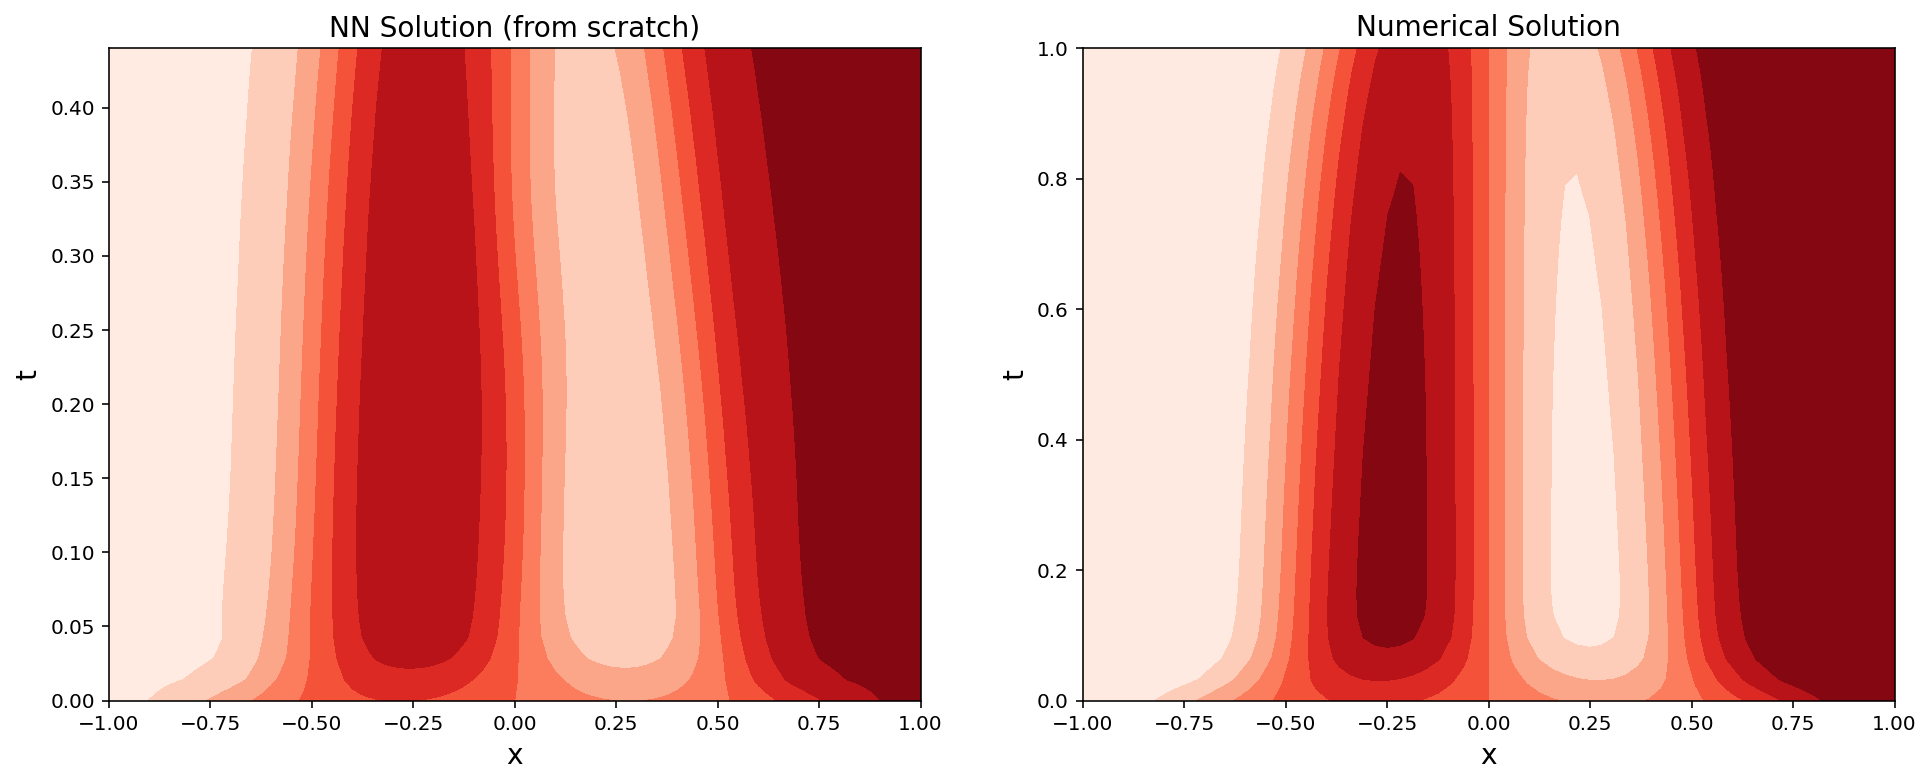

In [64]:
fig, ax = plt.subplots(1, 2, figsize=(16,6))
ax[0].set_title('NN Solution (from scratch)', fontsize=14)
cf1 = ax[0].contourf(x_grid, t_grid, u_nn.T, cmap="Reds")
ax[0].set_xlabel('x', fontsize=14), ax[0].set_ylabel('t', fontsize=14)
ax[1].set_title('Numerical Solution', fontsize=14)
ax[1].set_xlabel('x', fontsize=14), ax[1].set_ylabel('t', fontsize=14)
cf2 = ax[1].contourf(x_grid_num, t_grid_num, sol.T, cmap="Reds")

In [65]:
u_nn.shape

(101, 71)

In [63]:
x_grid.shape

(71, 101)

In [64]:
sol.shape

(101, 71)

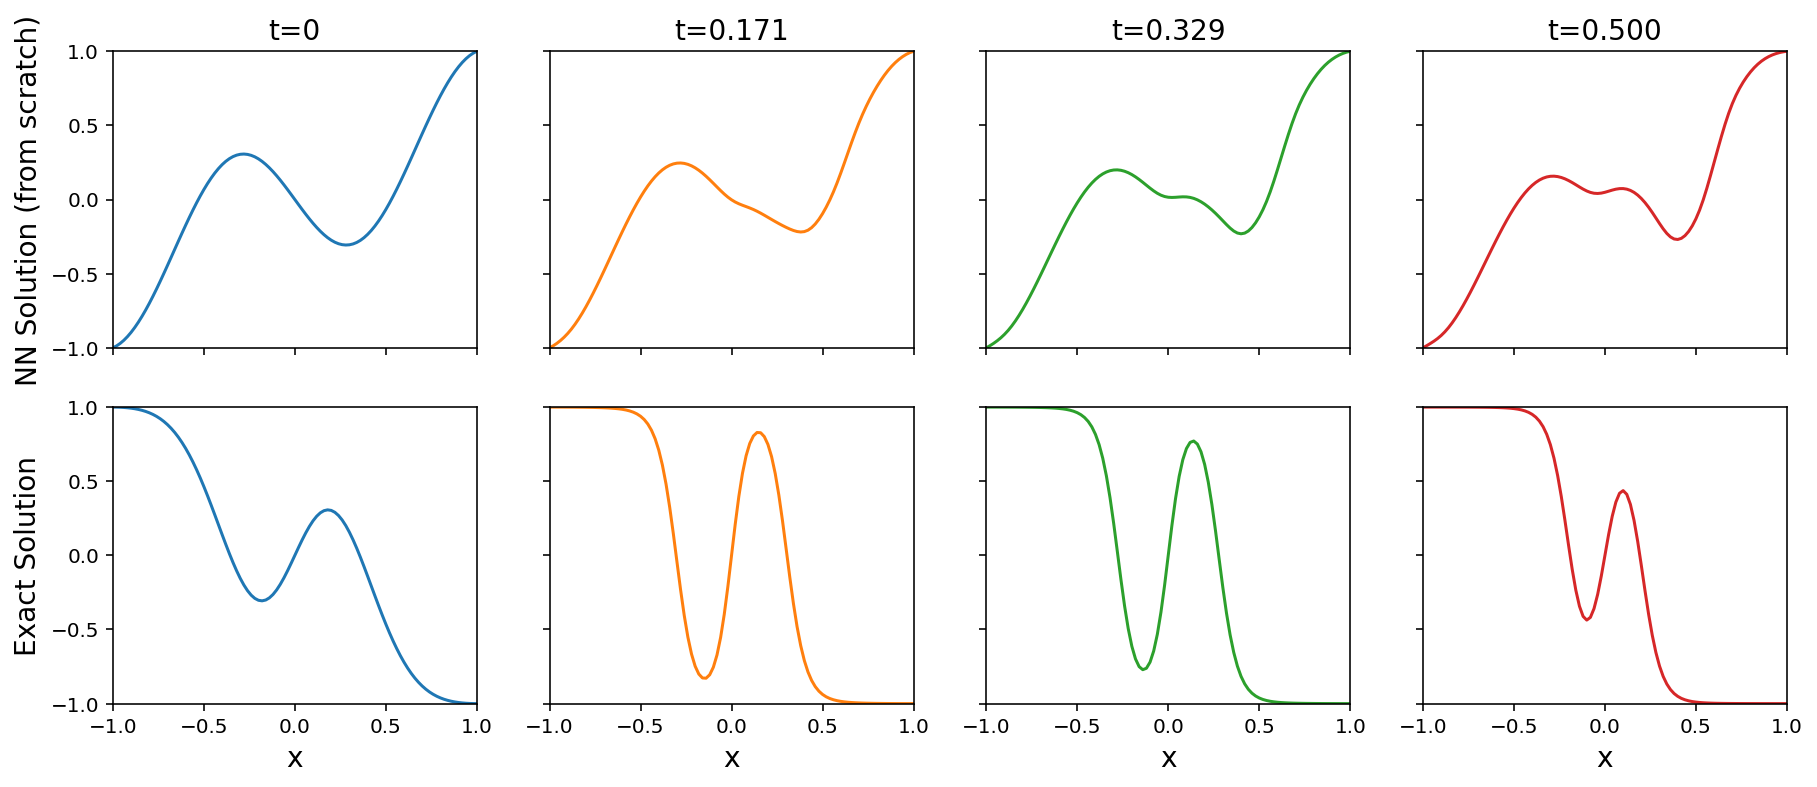

In [78]:
fig, axs = plt.subplots(2, 4, figsize=(15,6))
axs[0, 0].plot(x_axis, u_nn[:,0], 'tab:blue'), axs[0, 0].set_xlim([x_min_p,x_max_p]), axs[0, 0].set_ylim([-1,1]), axs[0, 0].set_title('t=0', fontsize=14)
axs[0, 1].plot(x_axis, u_nn[:,12], 'tab:orange'), axs[0, 1].set_xlim([x_min_p,x_max_p]), axs[0, 1].set_ylim([-1,1]), axs[0, 1].set_title('t=0.171', fontsize=14)
axs[0, 2].plot(x_axis, u_nn[:,23], 'tab:green'), axs[0, 2].set_xlim([x_min_p,x_max_p]), axs[0, 2].set_ylim([-1,1]), axs[0, 2].set_title('t=0.329', fontsize=14)
axs[0, 3].plot(x_axis, u_nn[:,35], 'tab:red'), axs[0, 3].set_xlim([x_min_p,x_max_p]), axs[0, 3].set_ylim([-1,1]), axs[0, 3].set_title('t=0.500', fontsize=14)
axs[1, 0].plot(x_axis, sol[:,0], 'tab:blue'), axs[1, 0].set_xlim([x_min_p,x_max_p]), axs[1, 0].set_ylim([-1,1])
axs[1, 1].plot(x_axis, sol[:,12], 'tab:orange'), axs[1, 1].set_xlim([x_min_p,x_max_p]), axs[1, 1].set_ylim([-1,1])
axs[1, 2].plot(x_axis, sol[:,23], 'tab:green'), axs[1, 2].set_xlim([x_min_p,x_max_p]), axs[1, 2].set_ylim([-1,1])
axs[1, 3].plot(x_axis, sol[:,35], 'tab:red'), axs[1, 3].set_xlim([x_min_p,x_max_p]), axs[1, 3].set_ylim([-1,1])
for ax in axs.flat:
    ax.set_xlabel('x', fontsize=14)
for ax in axs[0, :]:
    ax.set_ylabel('NN Solution (from scratch)', fontsize=14)
for ax in axs[1, :]:
    ax.set_ylabel('Exact Solution', fontsize=14)
for ax in axs.flat:
    ax.label_outer()
plt.show()

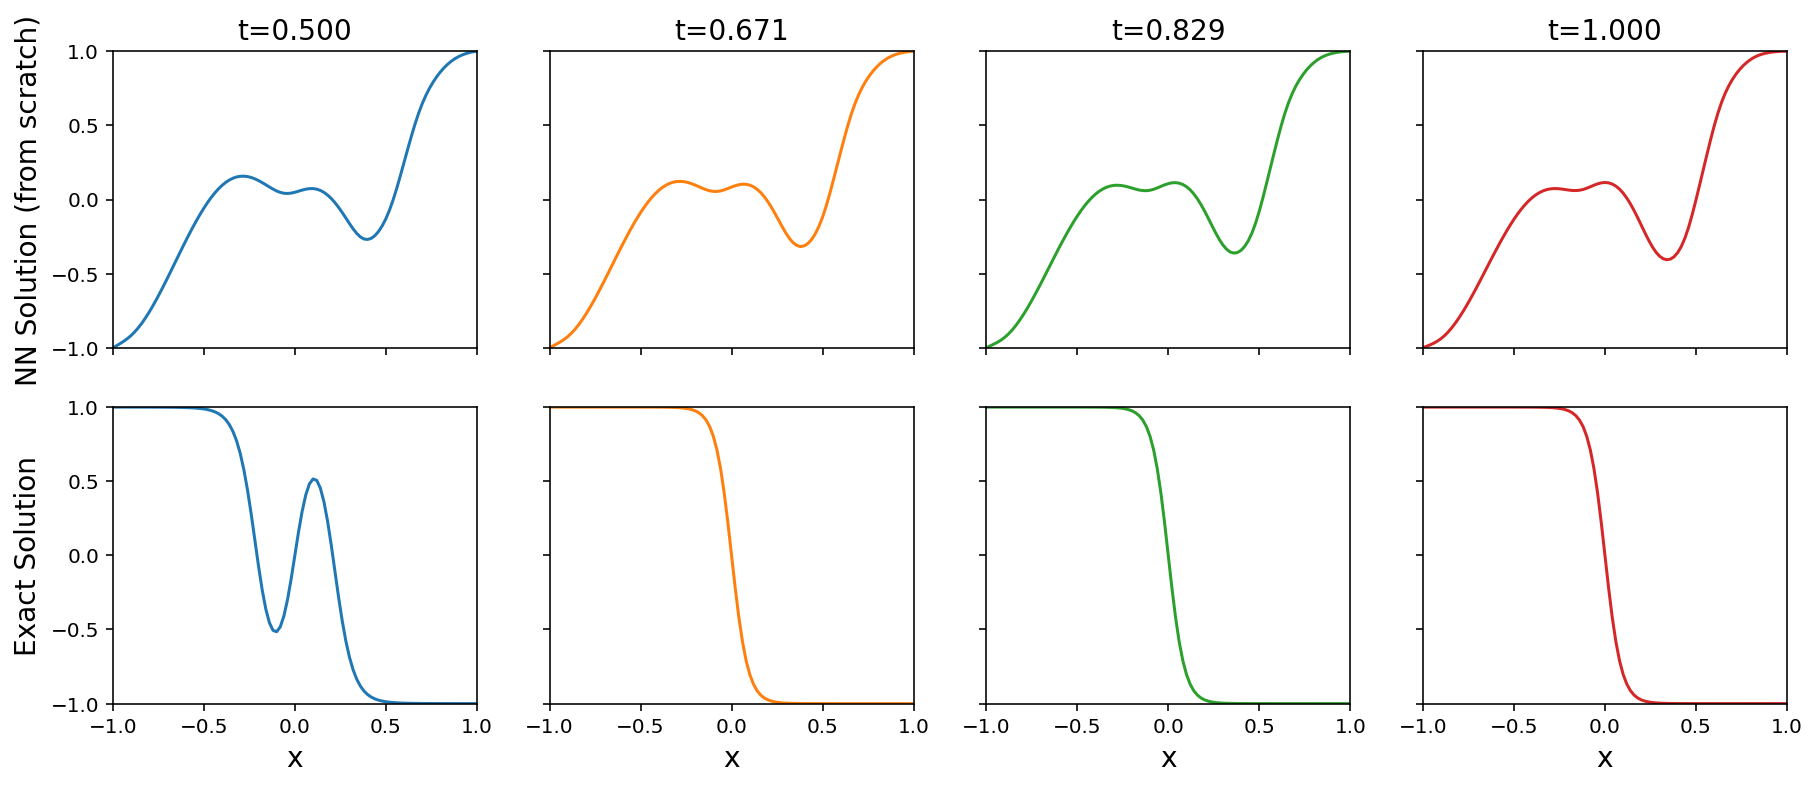

In [79]:
fig, axs = plt.subplots(2, 4, figsize=(15,6))
axs[0, 0].plot(x_axis, u_nn[:,35], 'tab:blue'), axs[0, 0].set_xlim([x_min_p,x_max_p]), axs[0, 0].set_ylim([-1,1]), axs[0, 0].set_title('t=0.500', fontsize=14)
axs[0, 1].plot(x_axis, u_nn[:,47], 'tab:orange'), axs[0, 1].set_xlim([x_min_p,x_max_p]), axs[0, 1].set_ylim([-1,1]), axs[0, 1].set_title('t=0.671', fontsize=14)
axs[0, 2].plot(x_axis, u_nn[:,58], 'tab:green'), axs[0, 2].set_xlim([x_min_p,x_max_p]), axs[0, 2].set_ylim([-1,1]), axs[0, 2].set_title('t=0.829', fontsize=14)
axs[0, 3].plot(x_axis, u_nn[:,nt_p], 'tab:red'), axs[0, 3].set_xlim([x_min_p,x_max_p]), axs[0, 3].set_ylim([-1,1]), axs[0, 3].set_title(f't=1.000', fontsize=14)
axs[1, 0].plot(x_axis, sol[:,34], 'tab:blue'), axs[1, 0].set_xlim([x_min_p,x_max_p]), axs[1, 0].set_ylim([-1,1])
axs[1, 1].plot(x_axis, sol[:,46], 'tab:orange'), axs[1, 1].set_xlim([x_min_p,x_max_p]), axs[1, 1].set_ylim([-1,1])
axs[1, 2].plot(x_axis, sol[:,58], 'tab:green'), axs[1, 2].set_xlim([x_min_p,x_max_p]), axs[1, 2].set_ylim([-1,1])
axs[1, 3].plot(x_axis, sol[:,nt_p], 'tab:red'), axs[1, 3].set_xlim([x_min_p,x_max_p]), axs[1, 3].set_ylim([-1,1])
for ax in axs.flat:
    ax.set_xlabel('x', fontsize=14)
for ax in axs[0, :]:
    ax.set_ylabel('NN Solution (from scratch)', fontsize=14)
for ax in axs[1, :]:
    ax.set_ylabel('Exact Solution', fontsize=14)
for ax in axs.flat:
    ax.label_outer()
plt.show()